# Text Mining - Document Summary

History:

- 2017/9/7: 
    - 移除文章內的google廣告
    - 用逗號和問號斷句
    - 加入similar words
        - check read01_summary
    - 加入兩張圖(tf-idf keywords, similar words)
        - check keywordmap
- 2017/9/11:
    - 建立user dict
    - 用jieba抓tfidf key words
- 2017/9/12:
    - word2vec
    - pca, tsne for visualization
    - LDA
- 2017/9/13:
    - add tf in bar chart
    - bar cahrt for LDA
    - w2v k-means clustering 
    - stop word在jieba.cut沒有作用, 改成再斷詞時另外處理
        - check stpwrdlst
- 2017/9/15
    - 過濾非文章內容的sentence and word
        - check data_delete, data_clean
    - update userdict.txt:
        - 工業四點零
    - 加入英文stop words
    - 加入中文stop words:
        - 則是
        - 將要
        - 則要
    - 加入tf-idf scatter plot
    - 修正key word from jieba tfidf
        - 改成用已經過濾過的sentence (word_str)

  

Reference:
- 用scikit-learn学习LDA主题模型
    - http://www.cnblogs.com/pinard/p/6908150.html
    - http://blog.csdn.net/eastmount/article/details/50824215
    
- 中文文本挖掘预处理流程总结
    - http://www.cnblogs.com/pinard/p/6744056.html
    
- Mining English and Korean text with Python
    https://www.lucypark.kr/courses/2015-ba/text-mining.html
    
- NLTK (POS, chunk, Parser tree)    
    - http://aweiho2015.pixnet.net/blog/post/10269587-%5B%E8%AA%8D%E8%AD%98%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86%28text-mining%29%5D--%E5%A6%82%E4%BD%95%E8%99%95%E7%90%86%E4%B8%80%E5%8F%A5
    
- TF-IDF and TextRank
    - http://zhicongchen.github.io/2016/11/22/TF-IDF-and-TextRank/
    
- 中文斷詞：斷句不要悲劇 / Head first Chinese text segmentation    
    - https://speakerdeck.com/fukuball/head-first-chinese-text-segmentation
    
- 文本分析之TFIDF/LDA/Word2vec实践
    - http://blog.csdn.net/vs412237401/article/details/50628239

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

import jieba
import jieba.analyse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import re
import ast

import random
from flask import Flask, g, render_template, request
import logging
import html_template as ht
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import collections
import pickle
import itertools
from IPython.display import HTML
import math
from sklearn import cluster, datasets, metrics


from collections import OrderedDict
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline

pd.set_option('display.max_columns', None)
punct = u'''\n +-％%:!),.:;?]}¢'"、。〉》」』】〕〗〞︰|︱︳丨﹐､﹒﹔﹕﹖﹗﹚﹜﹞！），．：；？｜｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠々‖•·ˇˉ―′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻︽︿﹁﹃﹙﹛﹝（｛“‘—_…~/#><'''
jieba.set_dictionary('dict.txt.big')
jieba.load_userdict('userdict.txt')


Building prefix dict from /Users/jayhsu/work/github/textmining/dict.txt.big ...
Loading model from cache /var/folders/yf/hq7ghg4j3ksb8k34wyh8vk2m0000gn/T/jieba.ub36e993abda9bbf53d1f5b38e3ae9b44.cache
Loading model cost 2.505 seconds.
Prefix dict has been built succesfully.


In [2]:
#中文字型
fp = matplotlib.font_manager.FontProperties(fname = 'font/NotoSansCJKtc-Regular.otf')
matplotlib.font_manager.fontManager.ttffiles.append(fp.get_file())
font_entry = matplotlib.font_manager.FontEntry(fp.get_file(), name=fp.get_name(),
                                               style=fp.get_style(), variant=fp.get_variant(),
                                              weight=fp.get_weight(), stretch=fp.get_stretch(), size=fp.get_size())

matplotlib.font_manager.fontManager.ttflist.append(font_entry)
plt.rcParams['font.family'] = fp.get_name()

stpwrdpath = "model/stop_words_new.txt"
stpwrd_dic = open(stpwrdpath, 'r')
stpwrd_content = stpwrd_dic.read()
stpwrdlst = stpwrd_content.splitlines()
stpwrd_dic.close()



In [3]:
def sort2list(list1, list2):
    list1, list2 = (list(t) for t in zip(*sorted(zip(list1, list2),reverse=True)))
    return list1, list2



In [4]:
data_cleanregex = ['\[SS_\w+\]','\(adsbygoogle.+\)\;']
data_deleteregex_ = [r'.*\.srt$']

def data_clean(dirty_str):
    tmp_str = dirty_str
    for pat in data_cleanregex:
        tmp_str = re.sub(pat, '', tmp_str)
    return tmp_str

data_deleteregex = list(map(lambda x: re.compile(x), data_deleteregex_))
def data_delete(dirty_str):
    tmp_str = dirty_str
    for pattern in data_deleteregex:
        #pattern = re.compile(pat)  
        match1 = pattern.match(dirty_str)
        if match1:
            return True
    return False   

def loaddocs(folder, topic):
    files = os.listdir('{f}/{w}'.format(f=folder, w=topic))
    docs=[]
    fileName=[]
    
    for fidx, fname in enumerate(files):
        if fname.startswith('.') or fname.endswith('.flag') :
            continue

        file = open('{fd}/{w}/{f}'.format(fd=folder, w=topic, f=fname), 'r') 
        doc =[] 
        for line in file.readlines():                          
            line = line.strip()
            if not len(line):                               
                continue
            if data_delete(line):
                continue
                
            line = data_clean(line)
            
            doc.append(line) 
        if len(doc)==0:
            continue
        docs.append('\n'.join(doc))
        fileName.append(str(fidx)+'_'+fname)
    dl_df = pd.DataFrame({'fname':fileName, 'doc':docs})
    return dl_df
    
def tokenize(dl_df):
    dl_df.sort_values(by='fname')
    dl_df['sentences']=dl_df['doc'].map(lambda x: re.split("[\n\r，。？]+", x))
    dl_df['words'] = dl_df['doc'].map(lambda x: [_.lower() for _ in jieba.cut(x) if _ not in punct and _ not in stpwrdlst]) 
    #dl_df['words_str'] = dl_df['words'].map(lambda x: ' '.join(x))
    return dl_df



def get_w2vmodel():
    dl_w2v_model = Word2Vec(dl_df['words'], min_count=1, size=100,iter=50)
    all_keywords = sum(list(dl_df['keywords']),[])
    vec = np.array([dl_w2v_model[w] for w in all_keywords if w in dl_w2v_model ])
    dl_pca = PCA(20)
    dl_pca.fit(vec)
    return dl_w2v_model, dl_pca, tfidf


***
***

In [5]:
folder_doc = 'text/techdoc'  
topic = '深度學習'#'深度學習' # 'MARK' #資料夾

** 一篇文章分析 ** 

In [178]:
#--Tokenize--
dl_df = loaddocs(folder = folder_doc, topic=topic)
dl_df= tokenize(dl_df)

#--MODEL--

dictionary = gensim.corpora.Dictionary(dl_df['words'])  
inverse_dict  = dictionary.token2id
corpus = [dictionary.doc2bow(text) for text in dl_df['words']] 
tfidf = gensim.models.TfidfModel(corpus)  
corpus_tfidf = tfidf[corpus]  

dl_w2v_model = Word2Vec(dl_df['words'], min_count=1, size=100,iter=50)

** 1. 檢查斷詞效果 **

In [167]:
docid=13

In [168]:
keywords_predefined = ['nvidia', 'geforce', 'gtx', 'titan', '深度學習','訓練系統','devbox']
keywords_predefined = list(map(lambda x:x.upper(), keywords_predefined))


In [169]:
print('斷詞:')
print(', '.join(list(dl_df['words'][docid])))

missing_words= list(filter(lambda x: x.upper() not in list(map(lambda x: x.upper(), dl_df['words'][docid])) , keywords_predefined))
print('\n\n\n沒斷好的word:{ms}\n\n'.format(ms=missing_words))

斷詞:
it168, 資訊, 解決, 當今世界, 尖端, 技術, 挑戰, nvidia, 剛剛, 推出, 全新, 硬體, 軟體, 前所未有, 提高, 深度學習, 研究, 速度, 易用性, 功用, 人工智慧, 領域, 快速, 成長, 深度學習, 技術, 一項, 創新, 計算, 引擎, 從先, 進, 醫藥, 研究, 全自動, 駕駛, 汽車, 多元, 領域, nvidia, 聯合, 創始人, 總裁兼, 執行長, 黃仁勛, gpu, 技術, 大會, 開幕, 主題, 演講, 活動, 在座, 四千名, 與會, 嘉賓, 展示, 三項, 推動, 深度學習, 新技術, nvidia, geforce, gtx, titan, x, 訓練, 深度神經網絡, 開發, 強大, 處理器, digits, 深度學習, gpu, 訓練, 系統, 數據科學家, 研究人員, 利用, 這套, 軟體, 便捷, 開發, 高品質, 深度神經網絡, digits, devbox, 全球, 最快, 桌邊型, 深度學習, 工具, 專為, 相關, 打造, 採用, titan, x, gpu, 搭配, 直觀, 易用, digits, 訓練, 系統, geforce, gtx, titan, x, 另一面, titanx, nvidia, 全新, 推出, 旗艦級, 遊戲, 顯卡, 特別, 適合, 深度學習, 舊金山, 舉辦, 遊戲, 開發者, 大會, 先睹為快, titan, x, 身影, 電影, 霍比特, 里, 史, 矛戈, 巨龍, 藍本, 播放, 一段, 名為, 暗影, 神偷, 精彩, 虛擬現實, 體驗, titanx, 上能, 4k, 超, 高畫質, 呈現, 最新, aaa, 遊戲, 大作, 瑰麗, 畫面, 開啟, fxaa, 高, 設定值, 情況, 每秒, 40, 幀, 40fps, 運行, 中土, 世界, 暗影, 魔多, middle, earth, shadow, mordor, 遊戲, 九月, 發行, geforce, gtx, 980, 上則, 30fps, 運行, 採用, nvidia, maxwell, gpu, 架構, titan, x, 3072, 核心, 單精度, 峰值, 性能, teraflops, 板載, 12gb, 顯存, 性能, 性能功耗比, 皆, 前代, 產品, 兩倍, 強大, 能力

** 2. extract key words **

 - TF-IDF (IDF: 100篇read01的深度學習文章)

Domain Keywords (user idf): 


,keyword,tfidf,idf,tf
0,digits,0.394,3.198780,0.123172
1,titan,0.273,3.198780,0.085345
2,devbox,0.265,4.658211,0.056889
3,nvidia,0.167,2.198780,0.075951
4,geforce,0.164,4.336283,0.037820
5,gtx,0.154,4.073249,0.037808
6,x,0.154,1.800230,0.085545
7,深度神經網絡,0.127,1.488286,0.085333
8,titanx,0.126,6.658211,0.018924
9,暗影,0.126,6.658211,0.018924


Predefined Keywords


,keyword,tfidf,idf,tf
1,titan,0.273,3.198780,0.085345
2,devbox,0.265,4.658211,0.056889
3,nvidia,0.167,2.198780,0.075951
4,geforce,0.164,4.336283,0.037820
5,gtx,0.154,4.073249,0.037808
274,深度學習,0.013,0.088356,0.147132


missing words: ['訓練系統']


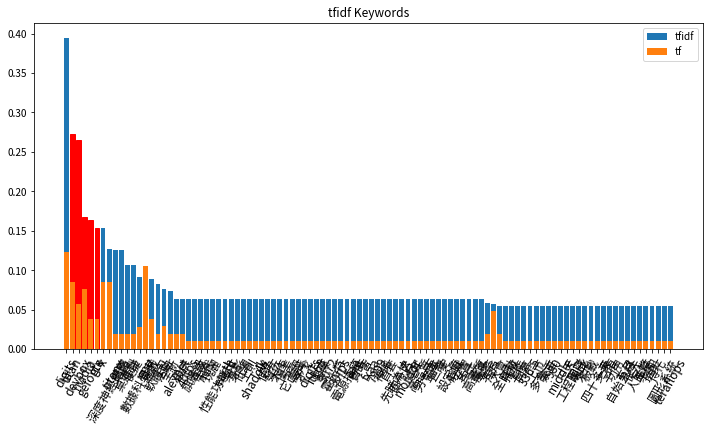

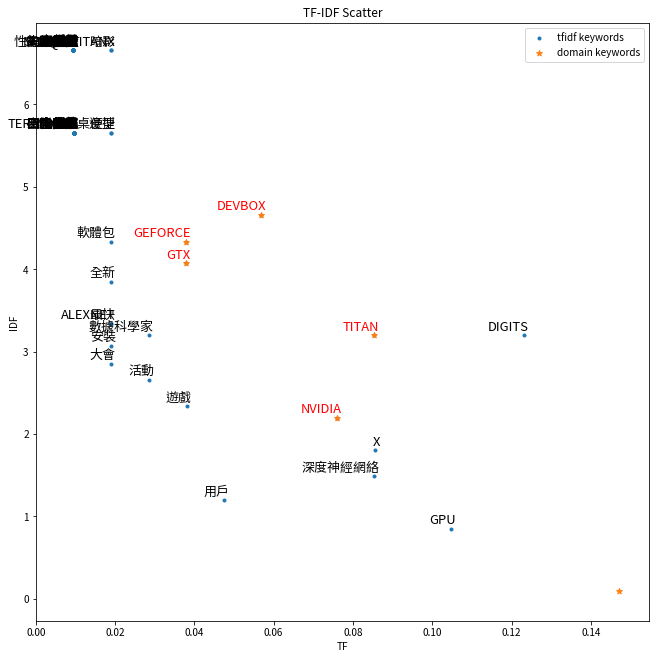

In [213]:
## 這邊的TF是次數

print('Domain Keywords (user idf): ')
topn = 100

tfidf_vec_id = corpus_tfidf[docid]
tfidf_vec_id = sorted(tfidf_vec_id, key=lambda tup: tup[1],reverse=True)
tfidf_vec_name = list(map(lambda x:(dictionary[x[0]],x[1]),tfidf_vec_id))
tfidf_vec_name = list(map(lambda x:(dictionary[x[0]],float('%.3f'% x[1])),tfidf_vec_id))

tfidf_df = pd.DataFrame(tfidf_vec_name, columns=['keyword','tfidf'])
tfidf_df['idf']=tfidf_df['keyword'].map(lambda x: tfidf.idfs[inverse_dict[x]])
tfidf_df['tf'] = tfidf_df['tfidf']/tfidf_df['idf']

#-- Visualization --
display(tfidf_df[:10])

print('Predefined Keywords')
tfidf_df['tmp'] = tfidf_df['keyword'].map(lambda x: x.upper())
missing_words= list(filter(lambda x: x.upper() not in list(tfidf_df['tmp']) , keywords_predefined))
predefined_df = tfidf_df.loc[tfidf_df['tmp'].isin(keywords_predefined)].drop('tmp', axis=1)
display(predefined_df)
print('missing words:',missing_words)

plt.figure(figsize=(12,6))
tfidf_df = tfidf_df[:topn]
barlist = plt.bar(range(len(tfidf_df['tfidf'])), tfidf_df['tfidf'], label='tfidf')
plt.bar(range(len(tfidf_df['tf'])), tfidf_df['tf'], label='tf')
plt.xticks(range(len(tfidf_df['keyword'])), tfidf_df['keyword'],rotation=60, fontsize=12)
plt.legend()
plt.title('tfidf Keywords')

for idx, kw in enumerate(tfidf_df['keyword']):
    if kw.upper() in keywords_predefined:
        barlist[idx].set_color('r')
plt.show()

    
fig = plt.figure(figsize=(11,11))
plt.scatter(tfidf_df['tf'], tfidf_df['idf'], label='tfidf keywords', marker='.')
plt.scatter(predefined_df['tf'], predefined_df['idf'], label='domain keywords', marker='*')

for i, label in enumerate(tfidf_df['keyword']):
    x = tfidf_df['tf'][i]
    y = tfidf_df['idf'][i]
    if label.upper() in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label.upper(),
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

plt.xlabel('TF')
plt.ylabel('IDF')
plt.title('TF-IDF Scatter')
plt.legend()
plt.show()

 - TF-IDF (IDF: jieba內建語料庫)

Domain Keywords (jieba idf): 


,keyword,tfidf,tf,idf
0,深度學習,0.402970,0.031315,12.868165
1,訓練,0.349240,0.027140,12.868165
2,digits,0.349240,0.027140,12.868165
3,titan,0.295511,0.018789,15.727758
4,gpu,0.295511,0.022965,12.868165
5,深度神經網絡,0.241782,0.018789,12.868165
6,系統,0.214917,0.016701,12.868165
7,nvidia,0.214917,0.016701,12.868165
8,devbox,0.161188,0.012526,12.868165
9,用戶,0.134323,0.010438,12.868165


Predefined Keywords


,keyword,tfidf,tf,idf
0,深度學習,0.402970,0.031315,12.868165
3,titan,0.295511,0.018789,15.727758
7,nvidia,0.214917,0.016701,12.868165
8,devbox,0.161188,0.012526,12.868165
10,geforce,0.107459,0.008351,12.868165
11,gtx,0.107459,0.008351,12.868165


missing words: ['訓練系統']


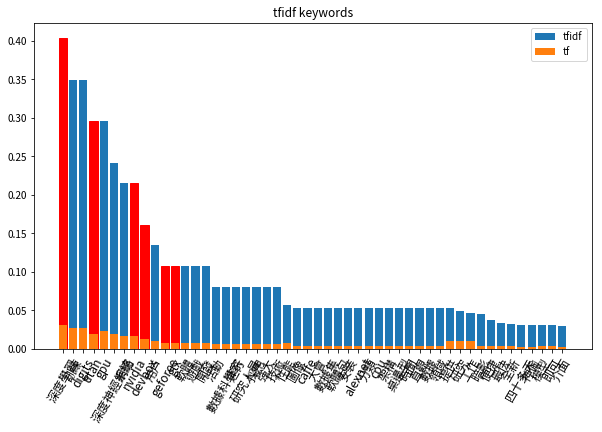

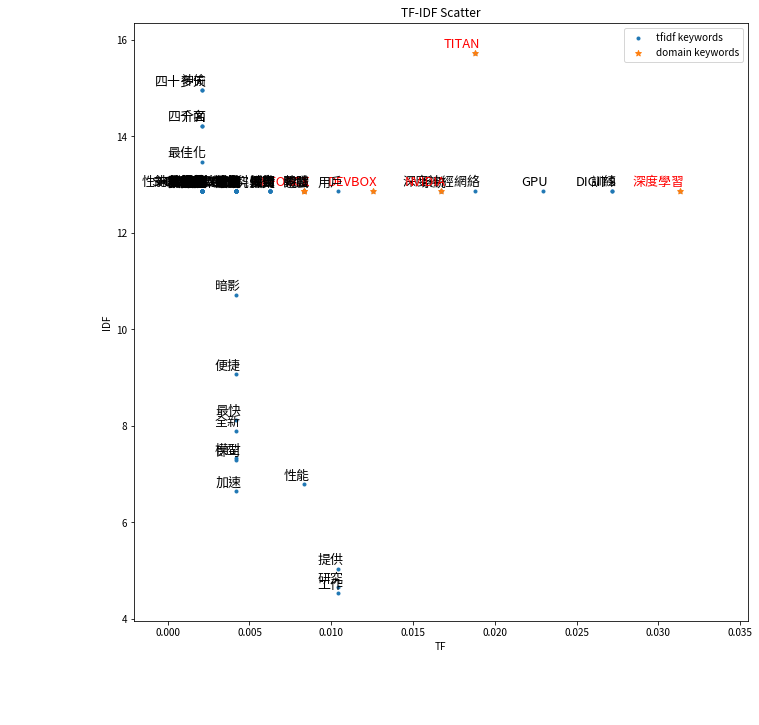

In [176]:
print('Domain Keywords (jieba idf): ')

words_str = ' '.join(dl_df['words'][docid])
tfidf_vec_jieba = jieba.analyse.tfidf(words_str,topK=None, withWeight=True)
tfidf_df_jieba = pd.DataFrame(tfidf_vec_jieba, columns=['keyword','tfidf'])
cv = CountVectorizer()
vecs1 = cv.fit_transform([words_str]).toarray()
vecs1 = vecs1[0]/len(dl_df['words'][docid])
fea = cv.get_feature_names()
tfidf_df_jieba['tf']=tfidf_df_jieba['keyword'].map(lambda x: vecs1[fea.index(x)] if x in fea else 0)
tfidf_df_jieba['idf']=tfidf_df_jieba['tfidf']/tfidf_df_jieba['tf']

display(tfidf_df_jieba[:10])

print('Predefined Keywords')
tfidf_df_jieba['tmp'] = tfidf_df_jieba['keyword'].map(lambda x: x.upper())
missing_words= list(filter(lambda x: x.upper() not in list(tfidf_df_jieba['tmp']) , keywords_predefined))
predefined_df = tfidf_df_jieba.loc[tfidf_df_jieba['tmp'].isin(keywords_predefined)].drop('tmp', axis=1)
display(predefined_df)
print('missing words:',missing_words)

tfidf_df_jieba=tfidf_df_jieba[:100]

disp_qty=50
plt.figure(figsize=(10,6))
xtmp=range(len(tfidf_df_jieba['tfidf'][:disp_qty]))
barlist = plt.bar(xtmp, tfidf_df_jieba['tfidf'][:disp_qty], label='tfidf')
plt.bar(xtmp, tfidf_df_jieba['tf'][:disp_qty], label='tf')
plt.xticks(xtmp, tfidf_df_jieba['keyword'][:disp_qty],rotation=60, fontsize=12)
plt.legend()
plt.title('tfidf keywords')



for idx, kw in enumerate(tfidf_df_jieba['keyword'][:disp_qty]):
    if kw.upper() in keywords_predefined:
        barlist[idx].set_color('r')

plt.show()

        
fig = plt.figure(figsize=(11,11))
plt.scatter(tfidf_df_jieba['tf'], tfidf_df_jieba['idf'], label='tfidf keywords', marker='.')
plt.scatter(predefined_df['tf'], predefined_df['idf'], label='domain keywords', marker='*')

for i, label in enumerate(tfidf_df_jieba['keyword']):
    x = tfidf_df_jieba['tf'][i]
    y = tfidf_df_jieba['idf'][i]
    if label.upper() in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label.upper(),
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

plt.xlabel('TF')
plt.ylabel('IDF')
plt.title('TF-IDF Scatter')
plt.legend()
plt.show()


**2.5. Similar Words **

In [430]:
tfidf_vec_id = corpus_tfidf[docid]
tfidf_vec_id = sorted(tfidf_vec_id, key=lambda tup: tup[1],reverse=True)
tfidf_vec_name = list(map(lambda x:(dictionary[x[0]],float('%.3f'% x[1])),tfidf_vec_id))
tfidf_df = pd.DataFrame(tfidf_vec_name, columns=['keyword','tfidf'])
keyword_list = dl_df['words'][docid]
tfidf_df['t_count']=tfidf_df['keyword'].map(lambda x: keyword_list.count(x))

print('similar words (tfidf keywords)')

#tfidf_df['similar words']=tfidf_df['keyword'].map(lambda kw: list(map(lambda x: (x[0], float('%.2f'% x[1])), dl_w2v_model.most_similar(kw,topn=10))))
#display(tfidf_df[:10])
tfidf_df['similar words']=tfidf_df['keyword'].map(lambda kw: list(map(lambda x: (x[0], float('%.2f'% x[1])), list(filter(lambda tup: tup[0] in keyword_list,dl_w2v_model.most_similar(kw,topn=30) )))))
tfidf_df = tfidf_df[:100]
tfidf_df = tfidf_df[tfidf_df['t_count']>3]

cluster=[]
keywords = tfidf_df['keyword']
for kw in keywords:
    kw_similarws = tfidf_df[tfidf_df['keyword']==kw]['similar words'].tolist()[0]
    if kw_similarws:
        kw_similarws = list(zip(*kw_similarws))[0]
    else:
        continue
    newCluster=True
    for c in cluster:
        merge=False
        for c_kw in c[1]:
            ckw_similarws = list(zip(*tfidf_df[tfidf_df['keyword']==c_kw]['similar words'].tolist()[0]))[0]
            if c_kw in kw_similarws and kw in ckw_similarws:
                merge=True
                break
        if merge:
            c[1].append(kw)
            newCluster=False
            break
    if newCluster:
        cluster.append((len(cluster)+1,[kw]))

        
        
display(cluster)
display(tfidf_df)

similar words (tfidf keywords)


[(1, ['digits', 'devbox', 'nvidia', 'geforce', 'gtx']),
 (2, ['titan', 'x']),
 (3, ['深度神經網絡']),
 (4, ['gpu']),
 (5, ['遊戲']),
 (6, ['用戶'])]

,keyword,tfidf,t_count,similar words
0,digits,0.394,13,"[(devbox, 0.79), (便捷, 0.74), (圖形系統, 0.7), (桌邊型, 0.69), (搭配, 0.68), (多合一, 0.67), (geforce, 0.65), (專為, 0.64), (工程團隊, 0.62), (加載, 0.62), (軟體包, 0.6), (易用, 0.6), (下載, 0.6)]"
1,titan,0.273,9,"[(gtx, 0.85), (maxwell, 0.8), (devbox, 0.8), (geforce, 0.79), (x, 0.78), (身影, 0.76), (搭配, 0.74), (旗艦級, 0.74), (顯卡, 0.72), (先睹為快, 0.72), (nvidia, 0.7), (12gb, 0.7)]"
2,devbox,0.265,6,"[(titan, 0.8), (geforce, 0.79), (digits, 0.79), (maxwell, 0.78), (專為, 0.78), (gtx, 0.76), (桌邊型, 0.75), (發行, 0.74), (nvidia, 0.74), (旗艦級, 0.73), (搭配, 0.72)]"
3,nvidia,0.167,8,"[(maxwell, 0.83), (搭配, 0.79), (顯卡, 0.75), (geforce, 0.75), (devbox, 0.74), (cudnn, 0.73), (titan, 0.7)]"
4,geforce,0.164,4,"[(另一面, 0.82), (titan, 0.79), (devbox, 0.79), (gtx, 0.78), (maxwell, 0.78), (搭配, 0.75), (nvidia, 0.75), (發行, 0.74), (旗艦級, 0.73), (顯卡, 0.73)]"
5,gtx,0.154,4,"[(980, 0.87), (發行, 0.85), (titan, 0.85), (上則, 0.79), (12gb, 0.79), (售價, 0.78), (geforce, 0.78), (身影, 0.77), (maxwell, 0.76)]"
6,x,0.154,9,"[(titan, 0.78), (身影, 0.67), (霍比特, 0.66)]"
7,深度神經網絡,0.127,9,"[(挑戰, 0.52), (神經網絡, 0.48), (digits, 0.48), (深度學習, 0.44)]"
13,gpu,0.089,11,"[(cpu, 0.69), (處理器, 0.62), (得花, 0.61), (顯存, 0.61), (帶寬, 0.58), (maxwell, 0.58), (搭配, 0.57), (nvidia, 0.57), (四十多天, 0.56), (加速, 0.56)]"
14,遊戲,0.089,4,"[(電腦, 0.66), (電影, 0.66), (虛擬現實, 0.65)]"


In [ ]:
tfidf_df['tmp'] = tfidf_df['keyword'].map(lambda x: x.upper())
predefined_df = tfidf_df.loc[tfidf_df['tmp'].isin(keywords_predefined)].drop('tmp', axis=1)
#predefined_df['similar words']=predefined_df['keyword'].map(lambda kw: list(map(lambda x: (x[0], float('%.3f'% x[1])), dl_w2v_model.most_similar(kw,topn=10))))
predefined_df['similar words']=predefined_df['keyword'].map(lambda kw: list(map(lambda x: (x[0], float('%.3f'% x[1])), list(filter(lambda tup: tup[0] in keyword_list,dl_w2v_model.most_similar(kw,topn=20) )))))
print('similar words (predefined keywords)')
display(predefined_df)

  - word2vec word similarity 

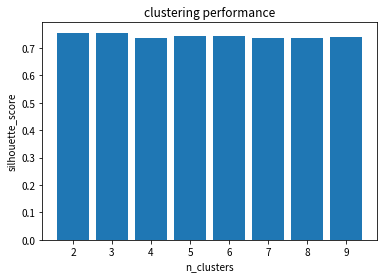

[0.75564194, 0.75322324, 0.73608375, 0.74241847, 0.7451449, 0.73697174, 0.73650193, 0.74145716]
Clustering by k-means: 


,0,1,2,3,4
0,devbox,titan,digits,用戶,深度神經網絡
1,geforce,gtx,nvidia,NaN,NaN
2,titanx,x,gpu,NaN,NaN
3,暗影,NaN,安裝,NaN,NaN
4,桌邊型,NaN,NaN,NaN,NaN
5,便捷,NaN,NaN,NaN,NaN
6,數據科學家,NaN,NaN,NaN,NaN
7,遊戲,NaN,NaN,NaN,NaN
8,軟體包,NaN,NaN,NaN,NaN
9,活動,NaN,NaN,NaN,NaN


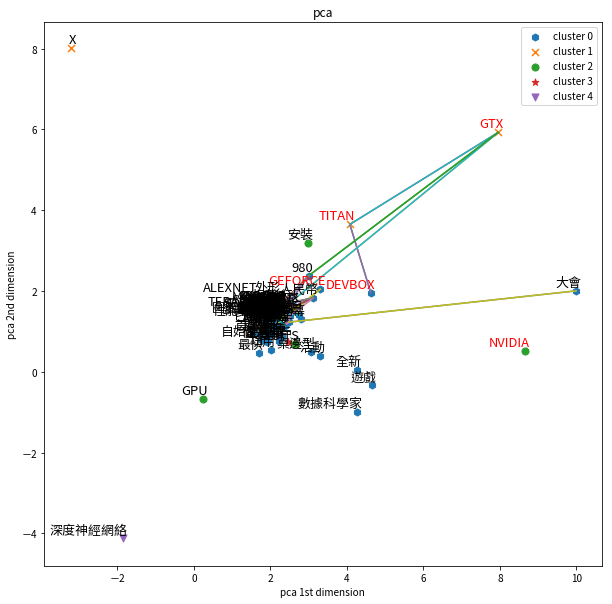

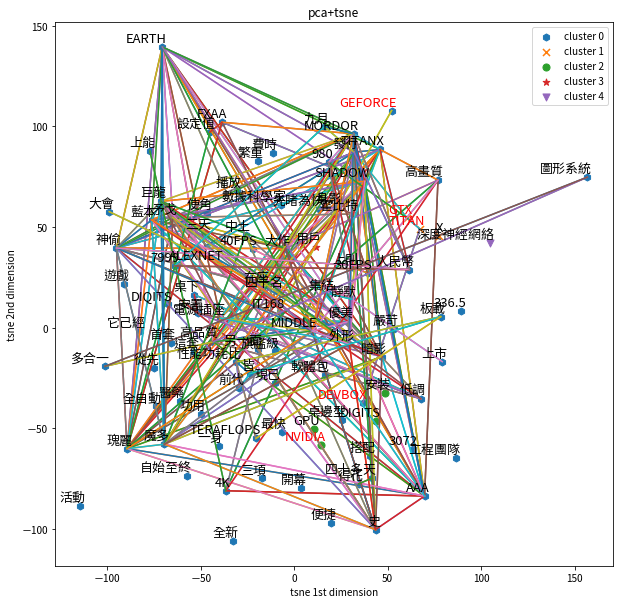

In [215]:
clusters=5


vec = np.array([dl_w2v_model[w] for w in sum(list(dl_df['words']),[]) if w in dl_w2v_model ])
dl_pca = PCA(20)
dl_pca.fit(vec)


kw_x= tfidf_df['keyword'].tolist()[:100]
vec_kw = [list(dl_w2v_model[w.lower()]) for w in kw_x]


silhouette_avgs = []
ks = range(2, 10)
for k in ks:
    kmeans_fit = KMeans(n_clusters = k).fit(np.array(vec_kw))
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(np.array(vec_kw), cluster_labels)
    silhouette_avgs.append(silhouette_avg)
plt.bar(ks, silhouette_avgs)
plt.title('clustering performance')
plt.ylabel('silhouette_score')
plt.xlabel('n_clusters')
plt.show()
print(silhouette_avgs)


kmeans_fit = KMeans(n_clusters=clusters).fit(np.array(vec_kw))
silhouette_avg_ = metrics.silhouette_score(np.array(vec_kw), kmeans_fit.labels_,metric='euclidean')
#['cityblock', 'cosine', 'euclidean', 'l1', 'l2','manhattan']
group=w2vkmeans.predict(vec_kw)
group_dic ={} 
for i in range(clusters):
    idx = np.argwhere([x ==i for x in group ])
    group_dic[i]=np.array(kw_x)[idx.flatten().tolist()].tolist()
print('Clustering by k-means: ')
display(pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in group_dic.items() ]))[:15])


vec_pca = dl_pca.transform(vec_kw)
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=10000,)
vec_tsne = tsne.fit_transform(vec_pca)

plt.clf()
fig = plt.figure(figsize=(10,10))
marker = itertools.cycle(['h', 'x', 'o', '*','v','d','h']) 
for i in range(clusters):
    idx = np.argwhere([x ==i for x in group ])
    data = vec_pca[idx.flatten().tolist()]
    plt.scatter(data[:, 0], data[:, 1], s= 50, label='cluster {g}'.format(g=i),marker=next(marker))
plt.legend()
plt.xlabel('pca 1st dimension')
plt.ylabel('pca 2nd dimension')

for i, label in enumerate(kw_x):
    x, y = vec_pca[i][:2]
    if label.upper() in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label.upper(),
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

for i1, label_1 in enumerate(kw_x):
    x1, y1 = vec_pca[i1][:2]
    for i2, label_2 in enumerate(kw_x):
        x2, y2 = vec_pca[i2][:2]
        similarity = dl_w2v_model.similarity(label_1.lower(), label_2.lower())
        if(similarity>0.8):
            plt.plot([x1,x2], [y1,y2])
plt.title('pca')
    
    
fig = plt.figure(figsize=(10,10))
marker = itertools.cycle(['h', 'x', 'o', '*','v','d','.']) 
for i in range(clusters):
    idx = np.argwhere([x ==i for x in group ])
    data = vec_tsne[idx.flatten().tolist()]
    plt.scatter(data[:, 0], data[:, 1], s= 50, label='cluster {g}'.format(g=i),marker=next(marker))
plt.legend()
plt.xlabel('tsne 1st dimension')
plt.ylabel('tsne 2nd dimension')


for i, label in enumerate(kw_x):
    x, y = vec_tsne[i][:2]
    if label.upper() in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label.upper(),
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

for i1, label_1 in enumerate(kw_x):
    x1, y1 = vec_tsne[i1][:2]
    for i2, label_2 in enumerate(kw_x):
        x2, y2 = vec_tsne[i2][:2]
        similarity = dl_w2v_model.similarity(label_1.lower(), label_2.lower())
        if(similarity>0.8):
            plt.plot([x1,x2], [y1,y2])
plt.title('pca+tsne')

- LDA 

In [224]:
doc = dl_df['doc'][13]
paragraph = doc.split('\n')

corpora_documents=[]
for p in paragraph:
    if p =='...':
        continue
    #p_cut = jieba.cut(p)
    p_cut = [_.lower() for _ in jieba.cut(p) if _ not in punct and _ not in stpwrdlst]
    corpora_documents.append(p_cut)
    
doc_dictionary = gensim.corpora.Dictionary(corpora_documents)  
doc_corpus = [doc_dictionary.doc2bow(text) for text in corpora_documents]  
doc_tfidf = gensim.models.TfidfModel(doc_corpus)  
doc_corpus_tfidf = doc_tfidf[corpus]  

In [325]:
topic_num = 5

doc = dl_df['doc'][13]
paragraph_ = doc.split('\n')
paragraph=[]
corpora_documents=[]
for p in paragraph_:
    if p =='...':
        continue
    paragraph.append(p)    
    #p_cut = jieba.cut(p)
    p_cut = [_.lower() for _ in jieba.cut(p) if _ not in punct and _ not in stpwrdlst]
    corpora_documents.append(p_cut)
    
doc_dictionary = gensim.corpora.Dictionary(corpora_documents)  
doc_corpus = [doc_dictionary.doc2bow(text) for text in corpora_documents]  
doc_tfidf = gensim.models.TfidfModel(doc_corpus)  
doc_corpus_tfidf = doc_tfidf[doc_corpus]  

    
print('#############'*4)  
lsi = gensim.models.lsimodel.LsiModel(corpus=doc_corpus, id2word=doc_dictionary, num_topics=topic_num)  
corpus_lsi = lsi[doc_corpus_tfidf]  
wordTopic = lsi.print_topics(-1)
wordTopic_df = pd.DataFrame(dict(list(map(lambda tup: (tup[0],tup[1].split('+')),wordTopic))))
sentTopic_df = pd.DataFrame(list(corpus_lsi))
sentTopic_df['sentence']=paragraph
sentTopic_df['topic']=list(list(zip(*np.argmax(corpus_lsi, axis=1)))[1])
display(wordTopic_df)
display(sentTopic_df.sort_values(by='topic'))


print('#############'*4)  
lda = gensim.models.ldamodel.LdaModel(corpus=doc_corpus, id2word=doc_dictionary, num_topics=topic_num, update_every=0, passes=1)  
corpus_lda = lda[doc_corpus_tfidf]  
    
wordTopic = lda.print_topics(-1)
wordTopic_ldadf = pd.DataFrame(dict(list(map(lambda tup: (tup[0],tup[1].split('+')),wordTopic))))
sentTopic_lda_df = pd.DataFrame(list(corpus_lda))
sentTopic_lda_df['sentence']=paragraph
sentTopic_lda_df['topic']=list(list(zip(*np.argmax(corpus_lsi, axis=1)))[1])
display(wordTopic_ldadf)
display(sentTopic_lda_df.sort_values(by='topic'))


####################################################


,0,1,2,3,4
0,"0.370*""訓練""","0.325*""遊戲""","0.316*""深度學習""","0.288*""系統""","0.262*""深度神經網絡"""
1,"0.366*""digits""","0.300*""運行""","-0.292*""訓練""","0.236*""用戶""","0.222*""深度學習"""
2,"0.345*""深度學習""","0.181*""geforce""","-0.229*""模型""","-0.234*""titan""","-0.208*""中"""
3,"0.329*""gpu""","0.181*""gtx""","-0.201*""titan""","-0.234*""x""","-0.206*""性能"""
4,"0.234*""系統""","0.170*""暗影""","-0.201*""x""","-0.202*""性能""","0.197*""nvidia"""
5,"0.196*""devbox""","0.157*""高""","-0.147*""強大""","0.199*""中""","-0.195*""devbox"""
6,"0.189*""深度神經網絡""","0.155*""titanx""","0.145*""nvidia""","-0.198*""深度學習""","-0.166*""gpu"""
7,"0.183*""titan""","0.143*""開啟""","-0.136*""alexnet""","-0.191*""nvidia""","-0.160*""x"""
8,"0.183*""x""","0.143*""fxaa""","-0.136*""時間""","0.151*""訓練""","-0.160*""titan"""
9,"0.143*""提供""","0.143*""世界""","-0.136*""cpu""","-0.141*""採用""","-0.158*""提供"""


,0,1,2,3,4,sentence,topic
25,"(0, 0.508926148656)","(1, -0.00806194047033)","(2, -0.155192025324)","(3, -0.0353113870404)","(4, -0.366149505615)",較早期的多GPU訓練成果顯示，在關鍵深度學習測試中，DIGITS DevBox可以提供4倍於單個TITAN X的性能。使用DIGITS DevBox來訓練AlexNet只要13個小時就能完成，而使用最好的單GPU PC的話則是兩天，單純使用CPU系統的話則要一個月以上的時間。,0
22,"(0, 0.252169326712)","(1, 0.00900683607333)","(2, 0.0317796255493)","(3, -0.287759348582)","(4, -0.282292986653)",它採用四個TITAN X GPU、從內存到I/O，DevBox的每個組件都進行了最佳化調試，可為最嚴苛的深度學習研究工作提供高效率的性能表現。,0
20,"(0, 0.217336185188)","(1, -0.0198580028428)","(2, 0.0715789623772)","(3, -0.0963410723307)","(4, -0.0773022572056)",DIGITS DevBox：全球最快的桌邊型深度學習機器,0
3,"(0, 0.277211954172)","(1, 0.166410254187)","(2, -0.154744598079)","(3, -0.101620977116)","(4, 0.135426121913)",·NVIDIA GeForce GTX TITAN X - 為訓練深度神經網絡而開發的最強大的處理器。,0
4,"(0, 0.352222932469)","(1, -0.0448025262723)","(2, 0.154157446542)","(3, 0.169353627401)","(4, 0.13086290809)",·DIGITS深度學習GPU訓練系統 - 數據科學家與研究人員能利用這套軟體便捷地開發出高品質深度神經網絡。,0
5,"(0, 0.374995540396)","(1, -0.0075877347438)","(2, -0.0168115354651)","(3, -0.104252895851)","(4, -0.189637644575)",·DIGITS DevBox - 全球最快的桌邊型深度學習工具 - 專為相關任務而打造，採用TITAN X GPU，搭配直觀易用的DIGITS訓練系統。,0
17,"(0, 0.231783237384)","(1, -0.0300335092099)","(2, 0.055103036397)","(3, 0.1276999311)","(4, 0.0731325155527)",DIGITS可在安裝、配置和訓練深度神經網絡過程中為用戶提供指導一處理複雜的工作好讓科學家能專心在研究活動和結果上。,0
16,"(0, 0.308532467794)","(1, -0.0182942780794)","(2, -0.034534926286)","(3, 0.123239233599)","(4, 0.216232696296)",訪問http://developer.nvidia.com/diqits即可下載DIGITS深度學習GPU訓練系統，這是首套用於設計、訓練和驗證圖像分類深度神經網絡的多合一圖形系統。,0
15,"(0, 0.332580730652)","(1, -0.0427612615942)","(2, 0.0464883730462)","(3, 0.256310855377)","(4, 0.0555481662635)",DIGITS深度學習 GPU 訓練系統軟體自始至終都將為用戶提供所需數據，幫助用戶建立最優的深度神經網絡，改變上述的局面。,0
13,"(0, 0.104929363614)","(1, -0.0113068298124)","(2, 0.00981615083136)","(3, 0.0496067623092)","(4, 0.0694246976434)",DIGITS：通往最佳深度神經網絡的便捷之路,0


####################################################


,0,1,2,3,4
0,"0.026*""訓練""","0.025*""系統""","0.027*""深度學習""","0.030*""深度學習""","0.023*""訓練"""
1,"0.021*""titan""","0.024*""gpu""","0.016*""digits""","0.022*""nvidia""","0.018*""nvidia"""
2,"0.021*""x""","0.024*""訓練""","0.014*""x""","0.018*""全新""","0.017*""digits"""
3,"0.021*""digits""","0.020*""digits""","0.014*""titan""","0.018*""推出""","0.016*""深度神經網絡"""
4,"0.018*""深度學習""","0.015*""深度神經網絡""","0.013*""nvidia""","0.017*""研究""","0.014*""強大"""
5,"0.016*""gpu""","0.015*""深度學習""","0.013*""gpu""","0.012*""digits""","0.014*""深度學習"""
6,"0.014*""深度神經網絡""","0.014*""中""","0.012*""大會""","0.011*""技術""","0.013*""即可"""
7,"0.014*""提供""","0.013*""研究人員""","0.010*""活動""","0.010*""遊戲""","0.013*""系統"""
8,"0.014*""研究""","0.012*""數據科學家""","0.010*""訓練""","0.010*""titanx""","0.013*""軟體包"""
9,"0.014*""用戶""","0.010*""devbox""","0.009*""devbox""","0.010*""工作""","0.013*""gpu"""


,0,1,2,3,4,sentence,topic
25,"(0, 0.0355568801094)","(1, 0.860989268565)","(2, 0.0345306142977)","(3, 0.0344422894076)","(4, 0.0344809476206)",較早期的多GPU訓練成果顯示，在關鍵深度學習測試中，DIGITS DevBox可以提供4倍於單個TITAN X的性能。使用DIGITS DevBox來訓練AlexNet只要13個小時就能完成，而使用最好的單GPU PC的話則是兩天，單純使用CPU系統的話則要一個月以上的時間。,0
22,"(0, 0.0392879251186)","(1, 0.0383395563335)","(2, 0.0383269805968)","(3, 0.845797023883)","(4, 0.038248514068)",它採用四個TITAN X GPU、從內存到I/O，DevBox的每個組件都進行了最佳化調試，可為最嚴苛的深度學習研究工作提供高效率的性能表現。,0
20,"(0, 0.0595833097545)","(1, 0.059159670678)","(2, 0.763743863971)","(3, 0.0588353907894)","(4, 0.0586777648066)",DIGITS DevBox：全球最快的桌邊型深度學習機器,0
3,"(0, 0.0531825085662)","(1, 0.0517003529069)","(2, 0.0522143617753)","(3, 0.0514185045871)","(4, 0.791484272165)",·NVIDIA GeForce GTX TITAN X - 為訓練深度神經網絡而開發的最強大的處理器。,0
4,"(0, 0.0461091806693)","(1, 0.815241002048)","(2, 0.0461488398819)","(3, 0.0462358112579)","(4, 0.046265166143)",·DIGITS深度學習GPU訓練系統 - 數據科學家與研究人員能利用這套軟體便捷地開發出高品質深度神經網絡。,0
5,"(0, 0.838418022173)","(1, 0.0405868517739)","(2, 0.0406358368488)","(3, 0.0400650783518)","(4, 0.0402942108529)",·DIGITS DevBox - 全球最快的桌邊型深度學習工具 - 專為相關任務而打造，採用TITAN X GPU，搭配直觀易用的DIGITS訓練系統。,0
17,"(0, 0.824904064494)","(1, 0.0437200973471)","(2, 0.0438299573861)","(3, 0.0437549460701)","(4, 0.0437909347026)",DIGITS可在安裝、配置和訓練深度神經網絡過程中為用戶提供指導一處理複雜的工作好讓科學家能專心在研究活動和結果上。,0
16,"(0, 0.0382811165098)","(1, 0.0383964045317)","(2, 0.0386030299675)","(3, 0.0381681465455)","(4, 0.846551302445)",訪問http://developer.nvidia.com/diqits即可下載DIGITS深度學習GPU訓練系統，這是首套用於設計、訓練和驗證圖像分類深度神經網絡的多合一圖形系統。,0
15,"(0, 0.824161044)","(1, 0.0441181573513)","(2, 0.0439476869805)","(3, 0.0438606208263)","(4, 0.0439124908422)",DIGITS深度學習 GPU 訓練系統軟體自始至終都將為用戶提供所需數據，幫助用戶建立最優的深度神經網絡，改變上述的局面。,0
13,"(0, 0.0621132569141)","(1, 0.0623904846775)","(2, 0.0618988690816)","(3, 0.751535588327)","(4, 0.0620618009999)",DIGITS：通往最佳深度神經網絡的便捷之路,0


topic_num = 5
doc = dl_df['doc'][13]
paragraph = doc.split('\n')

paragraph_cutstrlist=[]
for p in paragraph:
    if p =='...':
        continue
    #p_cut = jieba.cut(p)
    p_cut = [_.lower() for _ in jieba.cut(p) if _ not in punct and _ not in stpwrdlst]
    p_cut_str = ' '.join(p_cut)
    paragraph_cutstrlist.append(p_cut_str)

    
cntVector = CountVectorizer()
cntTf = cntVector.fit_transform(paragraph_cutstrlist)
fea = cntVector.get_feature_names()
vec_kw =cntTf.toarray().transpose()
#vec_kw = [list(dl_w2v_model[w.lower()]) if w in dl_w2v_model else [0]*dl_w2v_model.vector_size for w in fea ]

silhouette_avgs = []
ks = range(2, 10)
for k in ks:
    lda = LatentDirichletAllocation(n_topics=k,learning_method='batch')
    docres = lda.fit_transform(cntTf)
    label = list(map(lambda x: np.argmax(x), list(zip(*lda.components_))))
    silhouette_avg = metrics.silhouette_score(np.array(vec_kw), label)
    silhouette_avgs.append(silhouette_avg)
plt.bar(ks, silhouette_avgs)
plt.title('LDA performance')
plt.ylabel('silhouette_score')
plt.xlabel('n_topic')
plt.show()
print(silhouette_avgs)



lda = LatentDirichletAllocation(n_topics=topic_num,learning_method='batch')
docres = lda.fit_transform(cntTf)
label = list(map(lambda x: np.argmax(x), list(zip(*lda.components_))))
silhouette_avg_ = metrics.silhouette_score(np.array(vec_kw), label)


topiclist = np.argmax(docres, axis=1)
doc_topic = pd.DataFrame({ 'sentence:':paragraph_cutstrlist,'topic':topiclist})
display(doc_topic.sort_values(by='topic'))


lda_kwlist= []
for i in lda.components_:
    kw, weight = sort2list(i, fea)
    lda_kwlist.append(list(zip(kw,weight)))
topic_kw = pd.DataFrame(lda_kwlist)
topic_kw = topic_kw.transpose()
display(topic_kw[:6])


for i in range(topic_num):
    kw_y, kw_x,  = zip(*topic_kw[i])
    kw_y = list(map(lambda x: float('%.3f'% x),kw_y))

    plt.figure(figsize=(13,6))
    xtmp=range(len(kw_y[:40]))
    barlist = plt.bar(xtmp, kw_y[:40], label='tfidf')
    plt.bar(xtmp, tfidf_df['tf'][:40], label='tf')
    plt.xticks(xtmp, kw_x[:40],rotation=60, fontsize=12)
    plt.legend()
    plt.title('topic {n}'.format(n=i))
    #plt.ylim(0,0.4)

    for idx, kw in enumerate(kw_x[:40]):
        if kw.upper() in keywords_predefined:
            barlist[idx].set_color('r')


***

***
***
** flask web **

def keywordmap(lyrics_df, idx, w2v_model,pca,voc_dic, kw_size=30):
    figures=[]
    all_keywords = sum(list(lyrics_df['keywords']),[])
    counter = collections.Counter(all_keywords)
    if len(set(all_keywords)) <100:
        samples = len(set(all_keywords))
    else:
        samples = 100
    topn_keywords = [w[0] for w in counter.most_common(samples)]
    this_keyword = lyrics_df['keywords'][idx]

    vec = np.array([w2v_model[w] for w in (topn_keywords+this_keyword)])

    vec_pca = pca.transform(vec)
    topn_pca = vec_pca[:samples]
    this_pca = vec_pca[samples:]

    tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=10000)
    lowdim_embs = tsne.fit_transform(vec_pca)

    topn_lowdim_embs = lowdim_embs[:samples]
    this_lowdim_embs = lowdim_embs[samples:]
    
    plt.clf()
    fig = plt.figure(figsize=(20,10))
    figures.append(fig)
    plt.subplot(121)
    plt.scatter(topn_lowdim_embs[:, 0], topn_lowdim_embs[:, 1], s= 20, label='top 100 words')
    plt.scatter(this_lowdim_embs[:, 0], this_lowdim_embs[:, 1], s= 50, label='this topic key words', color='orange')
    plt.legend()
    plt.title('PCA + T-SNE')
    for i, label in enumerate(topn_keywords):
        if label in this_keyword:
            continue
        x, y = topn_lowdim_embs[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=12,
                     ha='right',
                     va='bottom')
    for i, label in enumerate(this_keyword):
        x, y = this_lowdim_embs[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=14,
                     ha='right',
                     va='bottom',color='orange')
    
    
    plt.subplot(122)
    plt.scatter(topn_pca[:, 0], topn_pca[:, 1], s= 20, label='top 100 words')
    plt.scatter(this_pca[:, 0], this_pca[:, 1], s= 50, label='this topic key words', color='orange')
    plt.legend()
    plt.title('PCA')
    for i, label in enumerate(topn_keywords):
        if label in this_keyword:
            continue
        x, y = topn_pca[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=12,
                     ha='right',
                     va='bottom')
    for i, label in enumerate(this_keyword):
        x, y = this_pca[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=14,
                     ha='right',
                     va='bottom',color='orange')


    fig2 = plt.figure(figsize=(15,6))
    figures.append(fig2)
    tfidf_vec = lyrics_df['tfidf_vector'][idx]
    topn_vec , topn_word= sort2list(list(tfidf_vec) , list(voc_dic.values()))
    plt.bar(range(len(topn_vec[:kw_size])), topn_vec[:kw_size])
    plt.xticks(range(len(topn_vec[:kw_size])), topn_word[:kw_size],rotation=60, fontsize=12)
    plt.title('tfidf keywords')
    #print(topn_word[:n])
    #plt.show()
    
    for kw in lyrics_df['keywords'][idx]:
        fig3 = plt.figure(figsize=(15,6))
        figures.append(fig3)
        similarwords = w2v_model.most_similar(kw, topn=kw_size)
        words, similarity = zip(*similarwords)
        barlist = plt.bar(range(len(similarity)), similarity)
        plt.xticks(range(len(similarity)), words,rotation=60, fontsize=12)
        plt.title('similar word of {kw}'.format(kw=kw))
        #barlist[0].set_color('r')
        #print(words)
        #plt.show()
    return figures

urls = [
    ['', '', '/', '']
    , ['deeplearningSummary', 'docid,topic', '/deeplearningSummary/0/4', 'test']
]
df_url = pd.DataFrame(urls, columns=['page', 'ps', 'instance', 'remark']).set_index('page')
df_url['instance'] = df_url['instance'].map(lambda x: '<a href="%s">%s</a>'%(x, x) if x != '' else '')


app = Flask(__name__)

def get_ps(page, path):
    names = df_url.ix[page]['ps'].split(',')
    try:
        ps = {k: v for k, v in zip(names, path.split('/'))}
    except:
        ps = {}
    return ps

def get_route(df_url, page):
    return '/%s'%page + ''.join(['/<%s>'%_ for _ in df_url.ix[page]['ps'].split(',') if len(_)>0 ])

@app.route('/')
def root(**ps):    
    cards = [['URL', [['table', df_url.reset_index()[['page', 'instance', 'ps', 'remark']]]] ]]
    try:
        texts = ['hi, %s'%flask_login.current_user.id]
    except:
        texts = []
    return ht.HtmlTemplate('Root', cards=cards, texts=texts).to_html()


topic_list=[w for w in os.listdir('text_dl') if not w.startswith('.')]
topic=-1
dl_df=None
dl_w2v_model=None
dl_pca=None
dl_voc_dic=None
@app.route('/deeplearningSummary/<path:path>')
def deeplearningSummary(path=''):
    global topic
    global dl_df
    global dl_w2v_model
    global dl_pca
    global dl_voc_dic
    #print(path)
    ps={}
    ps = get_ps('deeplearningSummary', path)
    #print(ps)
    docid = int(ps.get('docid'))  #docid
    topic_new = int(ps.get('topic'))  #topic
    print(topic_new)
    topic_str = topic_list[topic_new]
    
    if topic!=topic_new:
        dl_df, dl_voc_dic, dl_w2v_model, dl_pca = read01_summary(folder = 'text/techdoc', topic=topic_str, kw_topn=50)
        tipic=topic_new
    
    selected_doc = dl_df.ix[docid]
    
    cards = []
    content=[]
    
    display_detailcols=['fname', 'doc', 'keywords', 'summary']
    for col in display_detailcols:
        content.append(['text', '<font color="blue">{col}</font>'.format(col=col)])
        content.append(['text',selected_doc[col]])
    
    similarwords=OrderedDict()
    for kw in list(dl_df['keywords'][0]):
        similarword=dl_w2v_model.most_similar(kw,topn=20)
        similarwords[kw]=similarword
    similarwords_df = pd.DataFrame(similarwords)
    content.append(['text', '<font color="blue">{col}</font>'.format(col='similar words')])
    content.append(['table',similarwords_df])
    
    content.append(['text', '<font color="blue"> Text Summary</font>'])
    content.append(['table', dl_df[['fname','keywords','summary']]])
    
    cards.append(['text summary', content ])
    
    figs = keywordmap(dl_df, docid, dl_w2v_model, dl_pca,dl_voc_dic, kw_size=50)
    
    content=[]
    for f in figs:
        content.append(['fig', f])
    cards.append(['keyword map', content ])

    
    controls = []
    controls.append( ht.Control_Select(id='docid', text='doc', options=list(range(dl_df.shape[0])), value=docid, labels=list((dl_df['fname'])) ))
    controls.append( ht.Control_Select(id='topic', text='topic', options=list(range(len(topic_list))), value=topic_new, labels=topic_list ))
    
    return ht.HtmlTemplate('Text Summary App', ps, cards, controls=controls, page='deeplearningSummary').to_html()


if __name__ == '__main__':
    app.run(host='0.0.0.0',port=5001)


***
** 下面都沒用 **

In [ ]:
raw_documents = [  
    '无偿居间介绍买卖毒品的行为应如何定性',  
    '吸毒男动态持有大量毒品的行为该如何认定',  
    '如何区分是非法种植毒品原植物罪还是非法制造毒品罪',  
    '为毒贩贩卖毒品提供帮助构成贩卖毒品罪',  
    '将自己吸食的毒品原价转让给朋友吸食的行为该如何认定',  
    '为获报酬帮人购买毒品的行为该如何认定',  
    '毒贩出狱后再次够买毒品途中被抓的行为认定',  
    '虚夸毒品功效劝人吸食毒品的行为该如何认定',  
    '妻子下落不明丈夫又与他人登记结婚是否为无效婚姻',  
    '一方未签字办理的结婚登记是否有效',  
    '夫妻双方1990年按农村习俗举办婚礼没有结婚证 一方可否起诉离婚',  
    '结婚前对方父母出资购买的住房写我们二人的名字有效吗',  
    '身份证被别人冒用无法登记结婚怎么办？',  
    '同居后又与他人登记结婚是否构成重婚罪',  
    '未办登记只举办结婚仪式可起诉离婚吗',  
    '同居多年未办理结婚登记，是否可以向法院起诉要求离婚'  
]  
corpora_documents = list(map(lambda x: [_.lower() for _ in jieba.cut(x) if _ not in punct and _ not in stpwrdlst], raw_documents))
dictionary = gensim.corpora.Dictionary(corpora_documents)  
dictionary_ = dictionary.token2id
corpus = [dictionary.doc2bow(text) for text in corpora_documents]  

tfidf = gensim.models.TfidfModel(corpus)  
corpus_tfidf = tfidf[corpus]  


In [ ]:
corpus

In [ ]:
model = gensim.models.Word2Vec(corpora_documents,size=1000)  
print(model.most_similar('毒品',topn=10))  


In [ ]:

#根据结果使用lsi做主题分类效果会比较好  
print('#############'*4)  
lsi = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=dictionary, num_topics=2)  
corpus_lsi = lsi[corpus_tfidf]  
lsi.print_topics(2)  
for doc in corpus_lsi:  
    print(doc)  
  
print('#############'*4)  
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=2, update_every=0, passes=1)  
corpus_lda = lda[corpus_tfidf]  
lda.print_topics(2)  
for doc in corpus_lda:  
    print(doc)  


In [327]:
plot

NameError: name 'plot' is not defined